In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os
import os
import torch 
import random
import sys
import os
import numpy as np

### Import functions from .py files

In [3]:
scripts_path = os.path.abspath(os.path.join("..", "scripts"))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
    
from datacollection import *
from EPFmodels import *
from helpers import *
from BatteryEnv import * 
from DQN import *
from PPOd import *
from PPOc import *
from SAC import *
from heuristic import *

SEED = 2025
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)


## Data Collection and Visualization

### Price and Generation data:

,mean,std,min,25%,50%,75%,max
Price,138.28,113.14,-500.00,75.88,106.18,174.70,872.96
Solar,58.61,92.30,0.00,0.00,2.00,90.00,428.00
Wind Onshore,866.05,677.97,5.75,281.75,670.50,1358.25,2545.50
Wind Offshore,1320.14,1072.82,0.00,376.00,1071.75,2109.50,4343.00
Load Forecast (MW),11068.13,2244.72,478.75,9955.19,11119.75,12421.75,21256.75
Actual Aggregated,8650.90,2297.95,2571.25,6971.25,8411.75,10098.25,16632.75
temperature_2m,11.56,6.39,-7.40,7.00,11.30,16.20,34.60
cloudcover,68.82,38.91,0.00,31.00,97.00,100.00,100.00
sunshine_duration,1086.36,1597.11,0.00,0.00,0.00,3600.00,3600.00


ADF Test Statistic: -6.137140557205142
p-value: 8.13547481720705e-08
Critical Values: {'1%': -3.430599102593299, '5%': -2.8616500960359854, '10%': -2.5668286008605627}
The series is likely stationary (reject H0).


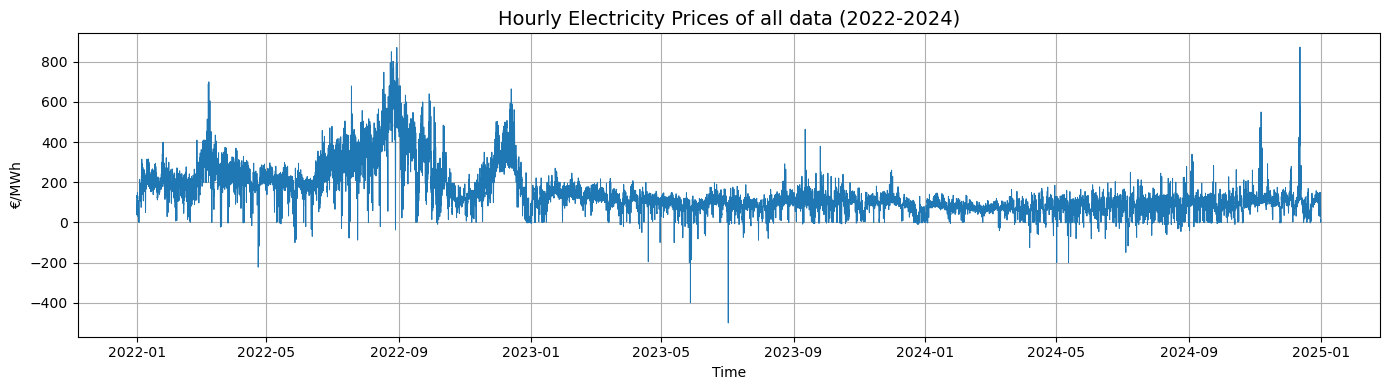

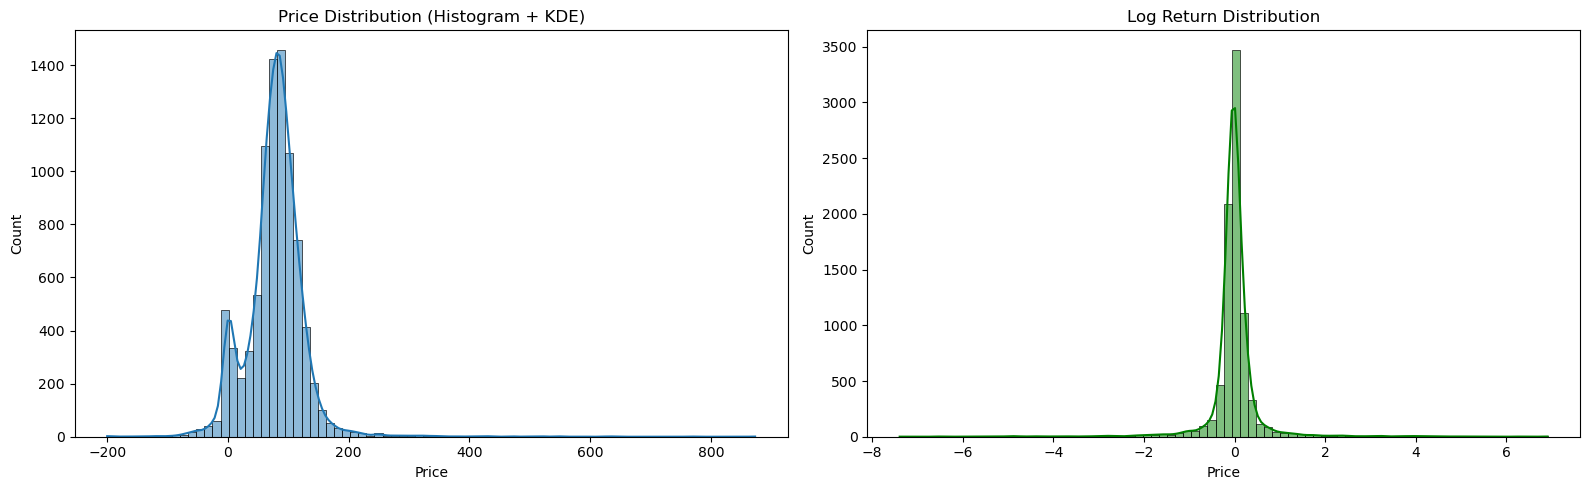

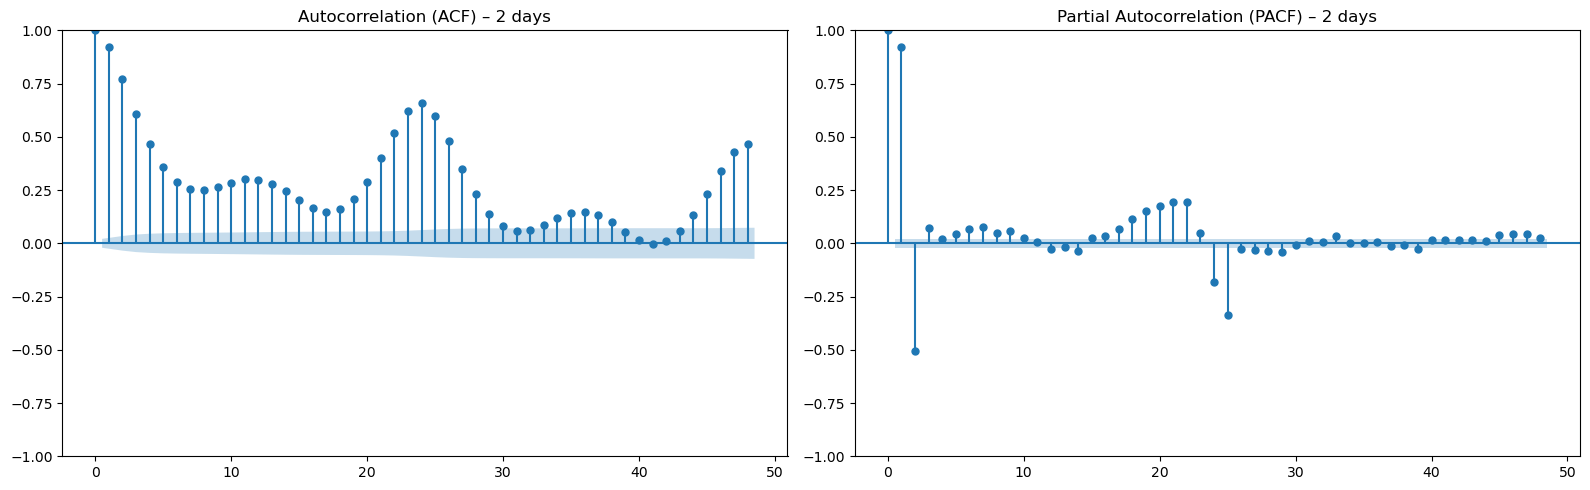

In [4]:
file_path = "../data/merged_energy_weather_2022_2024.csv"
price, price_scaled, exog, exog_raw, price_kWh = preprocess_energy_data(file_path)
get_descriptive(price, exog_raw)
pricevisualization(price)

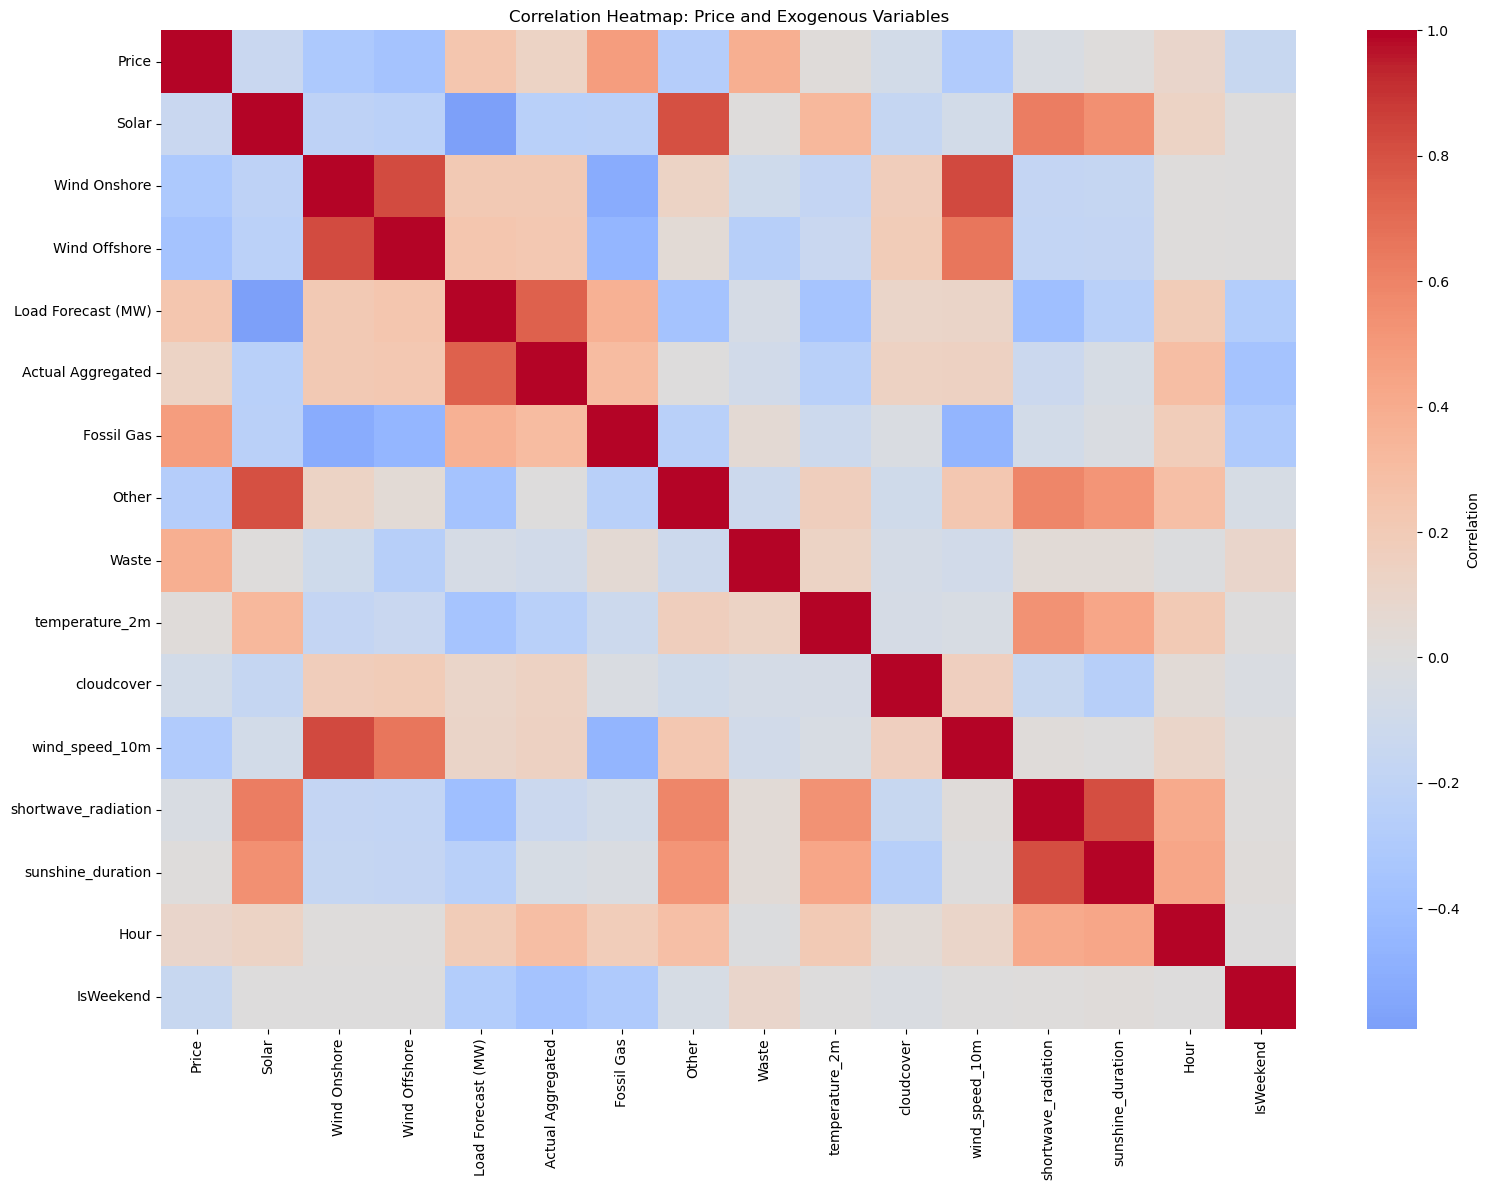

Correlation of each variable with Price:
Price                  1.000000
Fossil Gas             0.479829
Waste                  0.384778
Load Forecast (MW)     0.235831
Actual Aggregated      0.128870
Hour                   0.101942
temperature_2m         0.017717
sunshine_duration      0.013173
shortwave_radiation   -0.035356
cloudcover            -0.075977
Solar                 -0.138636
IsWeekend             -0.144607
Other                 -0.272758
wind_speed_10m        -0.291772
Wind Onshore          -0.315622
Wind Offshore         -0.361941
Name: Price, dtype: float64


In [5]:
correlation_analysis(price, exog)

### Simulated Firm-Specific Demand and Generation data

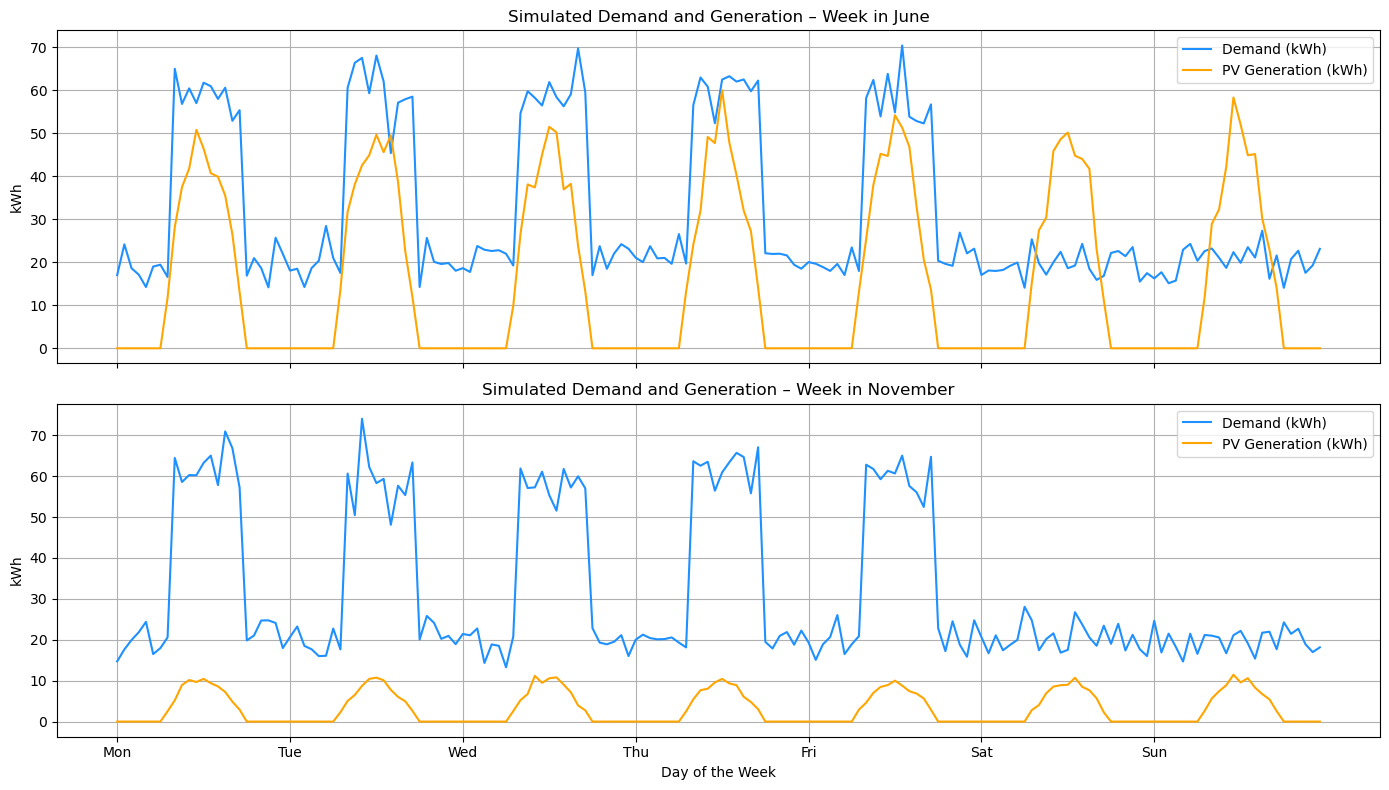

In [6]:
simdata = generate_simdata(price)
visualize_simdata(simdata)

## Energy Price Forecasting

In [7]:
########## Run forecasting models ########## (+/- 3,5 mins)

# Max window = 1040 days
# window = 1040
# AR_rmse , AR_mae, AR_t, AR_pred = rolling_forecast_AR(price, horizon=24, days=window)
# ARX_rmse, ARX_mae, ARX_t, ARX_pred = rolling_forecast_ARX(price, exog, horizon=24, days=window)
# LEAR_rmse, LEAR_mae, LEAR_t, LEAR_pred, true_prices, model_used_per_day = rolling_forecast_LEAR_with_AR_fallback(price, exog, horizon=24, days=window)

# # EPFperformance(AR_t, AR_rmse, AR_mae, ARX_t, ARX_rmse, ARX_mae, LEAR_t, LEAR_rmse, LEAR_mae)
# EPFperformance(AR_t, AR_rmse, AR_mae, ARX_t, ARX_rmse, ARX_mae, LEAR_t, LEAR_rmse, LEAR_mae, LEAR_pred, true_prices)


############ Save forecasts ########

# AR_pred.to_csv("AR_predictions_30_6.csv")
# ARX_pred.to_csv("ARX_predictions_30_6.csv")
# LEAR_pred.to_csv("LEAR_predictions_30_6.csv")

In [8]:
########## Or Load saved forecasts from data folder ########## 

AR_forecasts, _, LEAR_forecasts, perfect_foresight_forecasts = import_EPFforecasts("../data/AR_predictions_30_6.csv", "../data/LEAR_predictions_30_6.csv", price)

## Battery Control Strategies

### Heuristic

In [9]:
results_baseline = run_baseline_battery(simdata.loc["2024-01-01":"2024-12-31 23:00"])
no_batt_curve, batt_profit_curve, savings, pct_savings = evaluate_strategy(
    df_full=simdata,
    df_battery_result=results_baseline,
    start="2024-01-01",
    end="2024-12-31 23:00"
)

💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €16,963.71
✅ Savings from Battery:    €1,804.47
📉 Savings Percentage:       9.61%


In [10]:
traindata, testdata = align_and_split_data(price, simdata, AR_forecasts, LEAR_forecasts, perfect_foresight_forecasts, exog,
                                           train_end="2023-12-31 23:00:00", test_start="2024-01-01 00:00:00", tz="Europe/Amsterdam")

#### Hyperparameter tuning

In [11]:
# Hypertuning function in helpers.py

# # Hyperparameter tuning for DQN
# study_DQN = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_DQN.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="DQN"), n_trials=30)
# best_DQN = study_DQN.best_trial

# # Hyperparameter tuning for PPOd
# study_PPOd = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOd.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOd"), n_trials=30)
# best_PPOd = study_PPOd.best_trial

# # Hyperparameter tuning for PPOc
# study_PPOc = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOc.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOc"), n_trials=30)
# best_PPOc = study_PPOc.best_trial

# # Hyperparameter tuning for SAC
# study_SAC = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_SAC.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="SAC"), n_trials=30)
# best_SAC = study_SAC.best_trial

# print("\nBest hyperparameters found for DQN:")
# for k, v in best_DQN.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_DQN.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOd:")
# for k, v in best_PPOd.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOd.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOc:")
# for k, v in best_PPOc.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOc.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for SAC:")
# for k, v in best_SAC.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_SAC.value:.2f}%")

#### DQN for AR, LEAR, perfect foresight, sellratio 1.0
##### Optimized hyperparameters for DQN:  
 FOR LEAR  
  learning_rate: 0.0004457993980051172  
  batch_size: 128  
  gamma: 0.9142604076178287  
  timesteps: 116176  

In [12]:

learning_rate_DQN = 0.0004457993980051172  
batch_size_DQN = 128  
gamma_DQN = 0.9142604076178287  
timesteps_DQN = 116176 

# Load DQN models
results_dqn_ar = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_AR.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
    evaluation = True
)
print("")
results_dqn_lear = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_LEAR.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
    evaluation = True
)
print("")
results_dqn_perfect = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_perfect.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
    evaluation = True
)


##### used for convergence plots #####
# print("")
# results_dqn_lear_monitor = train_and_test_dqn(
#     train=traindata,
#     test=testdata,
#     simdata=simdata,
#     forecast_type="LEAR",
#     sell_price_ratio=1.0,
#     load_existing_model=False,
#     # model_load_path="../models/dqn_LEAR.zip",
#     timesteps=3000000,
#     learning_rate=learning_rate_DQN,
#     batch_size=batch_size_DQN,
#     gamma=gamma_DQN,
#     monitor = True
# )

Loading existing model from ../models/dqn_AR.zip
The model is now Testing DQN using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €14,008.52
✅ Savings from Battery:    €4,759.66
📉 Savings Percentage:       25.36%

Loading existing model from ../models/dqn_LEAR.zip
The model is now Testing DQN using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,158.80
✅ Savings from Battery:    €5,609.39
📉 Savings Percentage:       29.89%

Loading existing model from ../models/dqn_perfect.zip
The model is now Testing DQN using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,255.75
✅ Savings from Battery:    €5,512.43
📉 Savings Percentage:       29.37%


## PPO discrete for AR, LEAR, perfect foresight, sellratio 1.0
#### Optimized hyperparameters
FOR LEAR  
learning_rate: 0.00021391945303587435  
batch_size: 128  
gamma: 0.9037833289757886  
gae_lambda: 0.9023175195534727  
n_steps: 594  
timesteps: 1400000  

In [13]:

learning_rate_PPOd = 0.00021391945303587435 
batch_size_PPOd = 128
gamma_PPOd = 0.9037833289757886
gae_lambda_PPOd = 0.9023175195534727
n_steps_PPOd = 594
timesteps_PPOd = 1400000

# Load PPOd models
results_PPOd_ar = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_AR.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd,
    evaluation = True
)
print("")
results_PPOd_lear = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_LEAR.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=200000,
    evaluation = True
    
)
print("")
results_PPOd_perfect = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_perfect.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd,
    evaluation = True
)


##### Creates converging curve #####
# results_PPOd_lear_monitor = train_and_test_PPOd(
#     train=traindata,
#     test=testdata,
#     simdata=simdata,
#     forecast_type="LEAR",
#     sell_price_ratio=1.0,
#     load_existing_model=True,
#     # model_load_path="../models/ppo_d_LEAR.zip",
#     learning_rate=learning_rate_PPOd,
#     batch_size=batch_size_PPOd,
#     gamma=gamma_PPOd,
#     gae_lambda=gae_lambda_PPOd,
#     n_steps=n_steps_PPOd,
#     total_timesteps=3000000,
#     n_envs = 1,
#     monitor = True
# )

Loading existing PPO model from ../models/ppo_d_AR.zip
Testing PPO using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,215.01
✅ Savings from Battery:    €5,553.17
📉 Savings Percentage:       29.59%

Loading existing PPO model from ../models/ppo_d_LEAR.zip
Testing PPO using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €10,998.14
✅ Savings from Battery:    €7,770.05
📉 Savings Percentage:       41.40%

Loading existing PPO model from ../models/ppo_d_perfect.zip
Testing PPO using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €11,550.42
✅ Savings from Battery:    €7,217.76
📉 Savings Percentage:       38.46%


## PPO continuous for AR, LEAR, perfect foresight, sellratio = 1.0
#### Optimized hyperparameters
learning_rate: 0.00016734174724349077  
batch_size: 256  
gamma: 0.9384084377398001  
gae_lambda: 0.9244330236577202  
n_steps: 534  
timesteps: 1800000  

In [14]:
learning_rate_PPOc = 0.00016734174724349077
batch_size_PPOc = 256
gamma_PPOc = 0.9384084377398001
gae_lambda_PPOc = 0.9244330236577202
n_steps_PPOc = 534
timesteps_PPOc = 1800000

# Load PPOc models
results_PPOc_ar = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_AR.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
    evaluation = True
)
print("")
results_PPOc_lear = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_LEAR.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
    evaluation = True
)
print("")
results_PPOc_perfect = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_perfect.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
    evaluation = True
)

##### Creates converging curve #####
# results_PPOc_lear_monitor = train_and_test_PPOc(
#     train=traindata,
#     test=testdata,
#     simdata=simdata,
#     forecast_type="LEAR",
#     sell_price_ratio=1.0,
#     load_existing_model=False,
#     # model_load_path="../models/ppo_d_LEAR.zip",
#     learning_rate=learning_rate_PPOc,
#     batch_size=batch_size_PPOc,
#     gamma=gamma_PPOc,
#     gae_lambda=gae_lambda_PPOc,
#     n_steps=n_steps_PPOc,
#     total_timesteps=3000000,
#     n_envs = 1,
#     monitor = True
# )

Loading existing PPO continuous model from ../models/ppo_c_AR.zip
Testing PPO (continuous) using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €12,897.22
✅ Savings from Battery:    €5,870.97
📉 Savings Percentage:       31.28%

Loading existing PPO continuous model from ../models/ppo_c_LEAR.zip
Testing PPO (continuous) using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €11,255.38
✅ Savings from Battery:    €7,512.80
📉 Savings Percentage:       40.03%

Loading existing PPO continuous model from ../models/ppo_c_perfect.zip
Testing PPO (continuous) using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €10,860.63
✅ Savings from Battery:    €7,907.55
📉 Savings Percentage:       42.13%


## SAC for AR, LEAR, perfect foresight, sellratio = 1.0
Best hyperparameters found for SAC:  
  learning_rate: 0.000499013595187029  
  batch_size: 64  
  gamma: 0.9371648107316621  
  tau: 0.0051601218903209525  

Best savings percentage for LEAR: 32.48% 

In [15]:
learning_rate_SAC = 0.000499013595187029
batch_size_SAC = 64
gamma_SAC = 0.9371648107316621
tau_SAC = 0.0051601218903209525
timesteps_SAC = 500000


# Load SAC models
results_SAC_ar = train_and_test_SAC(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/sac_A500.zip",
    learning_rate=learning_rate_SAC,
    batch_size=batch_size_SAC,
    gamma=gamma_SAC,
    tau=tau_SAC,
    total_timesteps=timesteps_SAC,
    evaluation = True
)

results_SAC_lear = train_and_test_SAC(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/sac_LEAR500.zip",
    learning_rate=learning_rate_SAC,
    batch_size=batch_size_SAC,
    gamma=gamma_SAC,
    tau=tau_SAC,
    total_timesteps=timesteps_SAC,
    evaluation = True
)

results_SAC_perfect = train_and_test_SAC(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/sac_perfect500.zip",
    learning_rate=learning_rate_SAC,
    batch_size=batch_size_SAC,
    gamma=gamma_SAC,
    tau=tau_SAC,
    total_timesteps=timesteps_SAC,
    evaluation = True
)


##### Creates converging curve #####
# results_SAC_lear_monitor = train_and_test_SAC(
#     train=traindata,
#     test=testdata,
#     simdata=simdata,
#     forecast_type="LEAR",
#     sell_price_ratio=1.0,
#     load_existing_model=True,
#     # model_load_path="../models/ppo_d_LEAR.zip",
#     learning_rate=learning_rate_SAC,
#     batch_size=batch_size_SAC,
#     gamma=gamma_SAC,
#     tau=tau_SAC,
#     total_timesteps=3000000,
#     n_envs = 1,
#     monitor = True
# )

Loading existing SAC model from ../models/sac_A500.zip
Testing SAC using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €14,382.02
✅ Savings from Battery:    €4,386.16
📉 Savings Percentage:       23.37%
Loading existing SAC model from ../models/sac_LEAR500.zip
Testing SAC using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €12,622.60
✅ Savings from Battery:    €6,145.58
📉 Savings Percentage:       32.74%
Loading existing SAC model from ../models/sac_perfect500.zip
Testing SAC using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €12,254.03
✅ Savings from Battery:    €6,514.15
📉 Savings Percentage:       34.71%


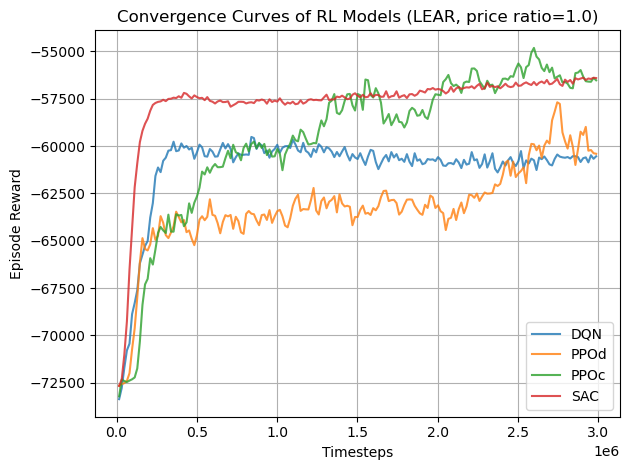

In [16]:
########## Plot convergence of RL models ##########

# Add SAC to the monitor files
monitor_files = {
    "DQN": "logs/DQN_LEAR_final_monitor.csv",
    "PPOd": "logs/PPOd_LEAR_monitor.csv",
    "PPOc": "logs/PPOc_LEAR_monitor.csv",
    "SAC": "logs/SAC_LEAR_monitor.csv"
}

for model_name, file_path in monitor_files.items(): 
    try: 
        df = pd.read_csv(file_path, skiprows=1) 
        timesteps = df["l"].cumsum() 
        rewards = df["r"] 
        plt.plot(timesteps, rewards, label=model_name, alpha=0.8) 
    except Exception as e: 
        print(f"Could not plot {model_name}: {e}")

plt.xlabel("Timesteps") 
plt.ylabel("Episode Reward") 
plt.title("Convergence Curves of RL Models (LEAR, price ratio=1.0)") 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show()

#### Cycle and Grid use analysis

In [17]:
# Estimate battery cycles, total grid interaction, and peak grid interaction for DQN, PPOd, PPOc (LEAR models)

battery_capacity = 200.0  # kWh

# DQN
df_dqn = results_dqn_lear[0]
soc_dqn = df_dqn["soc_kWh"].dropna().values
cycles_dqn = np.abs(np.diff(soc_dqn)).sum() / (2 * battery_capacity)
total_grid_dqn = df_dqn["grid_import_kWh"].sum() + df_dqn["grid_export_kWh"].sum()
peak_grid_dqn = max(df_dqn["grid_import_kWh"].max(), df_dqn["grid_export_kWh"].max())
print(f"DQN (LEAR): Estimated total battery cycles: {cycles_dqn:.2f}")
print(f"DQN (LEAR): Total grid interaction: {total_grid_dqn:.2f} kWh")
print(f"DQN (LEAR): Peak grid interaction (single hour): {peak_grid_dqn:.2f} kWh")

# PPOd
df_ppod = results_PPOd_lear[0]
soc_ppod = df_ppod["soc_kWh"].dropna().values
cycles_ppod = np.abs(np.diff(soc_ppod)).sum() / (2 * battery_capacity)
total_grid_ppod = df_ppod["grid_import_kWh"].sum() + df_ppod["grid_export_kWh"].sum()
peak_grid_ppod = max(df_ppod["grid_import_kWh"].max(), df_ppod["grid_export_kWh"].max())
print(f"PPOd (LEAR): Estimated total battery cycles: {cycles_ppod:.2f}")
print(f"PPOd (LEAR): Total grid interaction: {total_grid_ppod:.2f} kWh")
print(f"PPOd (LEAR): Peak grid interaction (single hour): {peak_grid_ppod:.2f} kWh")

# PPOc
df_ppoc = results_PPOc_lear[0]
soc_ppoc = df_ppoc["soc_kWh"].dropna().values
cycles_ppoc = np.abs(np.diff(soc_ppoc)).sum() / (2 * battery_capacity)
total_grid_ppoc = df_ppoc["grid_import_kWh"].sum() + df_ppoc["grid_export_kWh"].sum()
peak_grid_ppoc = max(df_ppoc["grid_import_kWh"].max(), df_ppoc["grid_export_kWh"].max())
print(f"PPOc (LEAR): Estimated total battery cycles: {cycles_ppoc:.2f}")
print(f"PPOc (LEAR): Total grid interaction: {total_grid_ppoc:.2f} kWh")
print(f"PPOc (LEAR): Peak grid interaction (single hour): {peak_grid_ppoc:.2f} kWh")

# SAC
df_sac = results_SAC_lear[0]
soc_sac = df_sac["soc_kWh"].dropna().values
cycles_sac = np.abs(np.diff(soc_sac)).sum() / (2 * battery_capacity)
total_grid_sac = df_sac["grid_import_kWh"].sum() + df_sac["grid_export_kWh"].sum()
peak_grid_sac = max(df_sac["grid_import_kWh"].max(), df_sac["grid_export_kWh"].max())
print(f"SAC (LEAR): Estimated total battery cycles: {cycles_sac:.2f}")
print(f"SAC (LEAR): Total grid interaction: {total_grid_sac:.2f} kWh")
print(f"SAC (LEAR): Peak grid interaction (single hour): {peak_grid_sac:.2f} kWh")

DQN (LEAR): Estimated total battery cycles: 624.12
DQN (LEAR): Total grid interaction: 449342.16 kWh
DQN (LEAR): Peak grid interaction (single hour): 174.64 kWh
PPOd (LEAR): Estimated total battery cycles: 749.36
PPOd (LEAR): Total grid interaction: 552393.44 kWh
PPOd (LEAR): Peak grid interaction (single hour): 173.35 kWh
PPOc (LEAR): Estimated total battery cycles: 745.63
PPOc (LEAR): Total grid interaction: 551444.42 kWh
PPOc (LEAR): Peak grid interaction (single hour): 172.79 kWh
SAC (LEAR): Estimated total battery cycles: 701.59
SAC (LEAR): Total grid interaction: 478548.42 kWh
SAC (LEAR): Peak grid interaction (single hour): 173.33 kWh


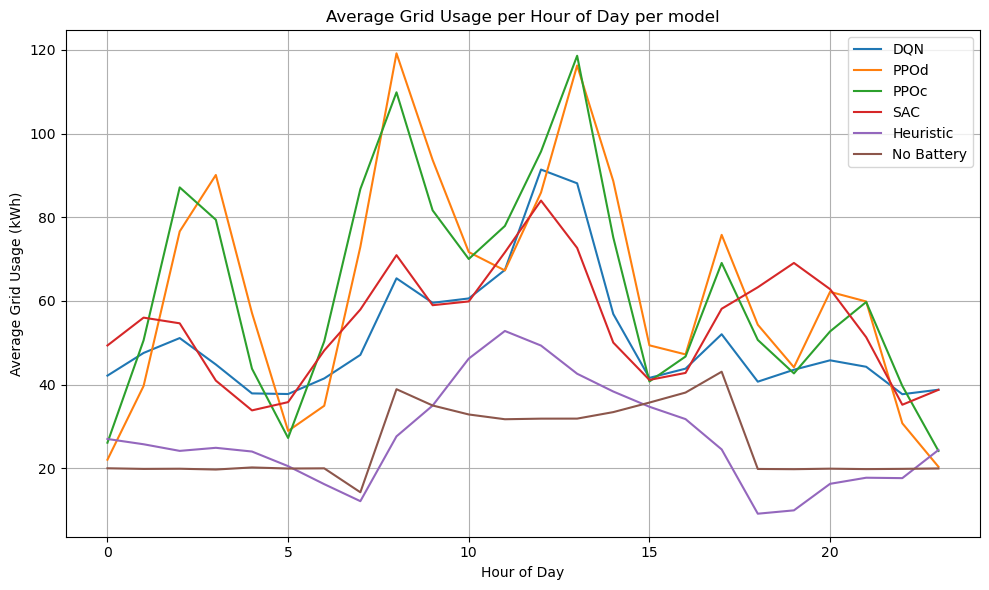

In [18]:
# Re-create DataFrames for each model (if not already defined)
df_dqn = results_dqn_lear[0]
df_ppod = results_PPOd_lear[0]
df_ppoc = results_PPOc_lear[0]
df_sac = results_SAC_lear[0]  # adjust if your SAC results are stored differently
df_heuristic = results_baseline  # or results_baseline[0] if it's a tuple/list

# Calculate hourly grid usage for each
hourly_grid_dqn = (df_dqn["grid_import_kWh"] + df_dqn["grid_export_kWh"]).groupby(df_dqn.index.hour).mean()
hourly_grid_ppod = (df_ppod["grid_import_kWh"] + df_ppod["grid_export_kWh"]).groupby(df_ppod.index.hour).mean()
hourly_grid_ppoc = (df_ppoc["grid_import_kWh"] + df_ppoc["grid_export_kWh"]).groupby(df_ppoc.index.hour).mean()
hourly_grid_sac = (df_sac["grid_import_kWh"] + df_sac["grid_export_kWh"]).groupby(df_sac.index.hour).mean()
hourly_grid_heuristic = (df_heuristic["from_grid"] + df_heuristic["energy_sold_kWh"]).groupby(df_heuristic.index.hour).mean()

# No battery baseline
df_no_batt = simdata.loc["2024-01-01":"2024-12-31 23:00"].copy()
df_no_batt["from_grid_no_batt"] = (df_no_batt["demand_kWh"] - df_no_batt["generation_kWh"]).clip(lower=0)
df_no_batt["energy_sold_no_batt"] = (df_no_batt["generation_kWh"] - df_no_batt["demand_kWh"]).clip(lower=0)
hourly_grid_no_batt = (df_no_batt["from_grid_no_batt"] + df_no_batt["energy_sold_no_batt"]).groupby(df_no_batt.index.hour).mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_grid_dqn.index, hourly_grid_dqn.values, label="DQN", marker='')
plt.plot(hourly_grid_ppod.index, hourly_grid_ppod.values, label="PPOd", marker='')
plt.plot(hourly_grid_ppoc.index, hourly_grid_ppoc.values, label="PPOc", marker='')
plt.plot(hourly_grid_sac.index, hourly_grid_sac.values, label="SAC", marker='')
plt.plot(hourly_grid_heuristic.index, hourly_grid_heuristic.values, label="Heuristic", marker='')
plt.plot(hourly_grid_no_batt.index, hourly_grid_no_batt.values, label="No Battery", marker='')

plt.xlabel("Hour of Day")
plt.ylabel("Average Grid Usage (kWh)")
plt.title("Average Grid Usage per Hour of Day per model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Hypertuning function in helpers.py
# sellratio = 0.3

# # Hyperparameter tuning for DQN
# study_DQN = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_DQN.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="DQN", sellratio = sellratio), n_trials=30)
# best_DQN = study_DQN.best_trial

# # Hyperparameter tuning for PPOd
# study_PPOd = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOd.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOd", sellratio = sellratio), n_trials=30)
# best_PPOd = study_PPOd.best_trial

# # Hyperparameter tuning for PPOc
# study_PPOc = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOc.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOc", sellratio = sellratio), n_trials=30)
# best_PPOc = study_PPOc.best_trial

# # Hyperparameter tuning for SAC
# study_SAC = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_SAC.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="SAC", sellratio = sellratio), n_trials=30)
# best_SAC = study_SAC.best_trial

# print("\nBest hyperparameters found for DQN:")
# for k, v in best_DQN.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_DQN.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOd:")
# for k, v in best_PPOd.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOd.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOc:")
# for k, v in best_PPOc.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOc.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for SAC:")
# for k, v in best_SAC.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_SAC.value:.2f}%")

### Tuned hyperparameters for sellratio = 0.3:

DQN:  

learning_rate: 0.0006657644772964915    
batch_size: 64  
gamma': 0.9713630741111118  

PPOd:  

learning_rate: 0.0006230122276052563
batch_size: 128   
gamma: 0.9610998258318779   
gae_lambda: 0.908951158661373  
n_steps: 376  


PPOc:  

learning_rate: 0.00024069212052509886   
batch_size: 256  
gamma: 0.9273734569814184  
gae_lambda: 0.9324807008474365  
n_steps: 531    

SAC:  

learning_rate: 0.0006323096385373458  
batch_size: 128  
gamma: 0.9827854732573155  
tau: 0.0001097628123047568  





### DQN, PPOd, PPOc, SAC for sellratio = 0.3

Training or loading and testing models using tuned hyperparameters for sellpriceratio = 0.3

In [20]:
sell_price_ratio = 0.3
timesteps_DQN = 115000  
timesteps_PPOd = 1400000
timesteps_PPOc = 1800000
timesteps_SAC = 500000

# DQN hyperparameters
learning_rate_DQN = 0.0006657644772964915
batch_size_DQN = 64
gamma_DQN = 0.9713630741111118

# PPOd hyperparameters
learning_rate_PPOd = 0.0006230122276052563
batch_size_PPOd = 128
gamma_PPOd = 0.9610998258318779
gae_lambda_PPOd = 0.908951158661373
n_steps_PPOd = 376

# PPOc hyperparameters
learning_rate_PPOc = 0.00024069212052509886
batch_size_PPOc = 256
gamma_PPOc = 0.9273734569814184
gae_lambda_PPOc = 0.9324807008474365
n_steps_PPOc = 531

# SAC hyperparameters
learning_rate_SAC = 0.0006323096385373458
batch_size_SAC = 128
gamma_SAC = 0.9827854732573155
tau_SAC = 0.0001097628123047568

# DQN
results_dqn_ar03 = train_and_test_dqn(
    train=traindata, test=testdata, simdata=simdata, forecast_type="AR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/dqn_AR_sr03.zip",
    timesteps=timesteps_DQN, learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN, gamma=gamma_DQN, evaluation=True
)
results_dqn_lear03 = train_and_test_dqn(
    train=traindata, test=testdata, simdata=simdata, forecast_type="LEAR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/dqn_LEAR_sr03.zip",
    timesteps=timesteps_DQN, learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN, gamma=gamma_DQN, evaluation=True
)
results_dqn_perfect03 = train_and_test_dqn(
    train=traindata, test=testdata, simdata=simdata, forecast_type="perfect",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/dqn_perfect_sr03.zip",
    timesteps=timesteps_DQN, learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN, gamma=gamma_DQN, evaluation=True
)

# PPOd
results_PPOd_ar03 = train_and_test_PPOd(
    train=traindata, test=testdata, simdata=simdata, forecast_type="AR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppod_AR_sr03.zip",
    learning_rate=learning_rate_PPOd, batch_size=batch_size_PPOd,
    gamma=gamma_PPOd, gae_lambda=gae_lambda_PPOd, n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd, evaluation=True
)
results_PPOd_lear03 = train_and_test_PPOd(
    train=traindata, test=testdata, simdata=simdata, forecast_type="LEAR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppod_LEAR_sr03.zip",
    learning_rate=learning_rate_PPOd, batch_size=batch_size_PPOd,
    gamma=gamma_PPOd, gae_lambda=gae_lambda_PPOd, n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd, evaluation=True
)
results_PPOd_perfect03 = train_and_test_PPOd(
    train=traindata, test=testdata, simdata=simdata, forecast_type="perfect",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppod_perfect_sr03.zip",
    learning_rate=learning_rate_PPOd, batch_size=batch_size_PPOd,
    gamma=gamma_PPOd, gae_lambda=gae_lambda_PPOd, n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd, evaluation=True
)

# PPOc
results_PPOc_ar03 = train_and_test_PPOc(
    train=traindata, test=testdata, simdata=simdata, forecast_type="AR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppoc_AR_sr03.zip",
    learning_rate=learning_rate_PPOc, batch_size=batch_size_PPOc,
    gamma=gamma_PPOc, gae_lambda=gae_lambda_PPOc, n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc, evaluation=True
)
results_PPOc_lear03 = train_and_test_PPOc(
    train=traindata, test=testdata, simdata=simdata, forecast_type="LEAR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppoc_LEAR_sr03.zip",
    learning_rate=learning_rate_PPOc, batch_size=batch_size_PPOc,
    gamma=gamma_PPOc, gae_lambda=gae_lambda_PPOc, n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc, evaluation=True
)
results_PPOc_perfect03 = train_and_test_PPOc(
    train=traindata, test=testdata, simdata=simdata, forecast_type="perfect",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/ppoc_perfect_sr03.zip",
    learning_rate=learning_rate_PPOc, batch_size=batch_size_PPOc,
    gamma=gamma_PPOc, gae_lambda=gae_lambda_PPOc, n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc, evaluation=True
)

# SAC
results_SAC_ar03 = train_and_test_SAC(
    train=traindata, test=testdata, simdata=simdata, forecast_type="AR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/sac_AR_sr03.zip",
    learning_rate=learning_rate_SAC, batch_size=batch_size_SAC,
    gamma=gamma_SAC, tau=tau_SAC, total_timesteps=timesteps_SAC, evaluation=True
)
results_SAC_lear03 = train_and_test_SAC(
    train=traindata, test=testdata, simdata=simdata, forecast_type="LEAR",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/sac_LEAR_sr03.zip",
    learning_rate=learning_rate_SAC, batch_size=batch_size_SAC,
    gamma=gamma_SAC, tau=tau_SAC, total_timesteps=timesteps_SAC, evaluation=True
)
results_SAC_perfect03 = train_and_test_SAC(
    train=traindata, test=testdata, simdata=simdata, forecast_type="perfect",
    sell_price_ratio=sell_price_ratio, load_existing_model=True,
    model_load_path="../models/sac_perfect_sr03.zip",
    learning_rate=learning_rate_SAC, batch_size=batch_size_SAC,
    gamma=gamma_SAC, tau=tau_SAC, total_timesteps=timesteps_SAC, evaluation=True
)


Loading existing model from ../models/dqn_AR_sr03.zip
The model is now Testing DQN using AR forecasts and sell price ratio: 0.3
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €17,071.74
✅ Savings from Battery:    €1,696.44
📉 Savings Percentage:       9.04%
Loading existing model from ../models/dqn_LEAR_sr03.zip
The model is now Testing DQN using LEAR forecasts and sell price ratio: 0.3
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €15,055.91
✅ Savings from Battery:    €3,712.28
📉 Savings Percentage:       19.78%
Loading existing model from ../models/dqn_perfect_sr03.zip
The model is now Testing DQN using perfect forecasts and sell price ratio: 0.3
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €15,977.78
✅ Savings from Battery:    €2,790.40
📉 Savings Percentage:       14.87%
Loading existing PPO model from ../models/ppod_AR_sr03.zip
Testing PPO using AR forecasts and sell price ratio: 0.3
💰 No Battery Cost:         €18,768.18
🔋 Wit

### Investigate grid use and dispatch behavior

In [21]:
# Estimate battery cycles, total grid interaction, and peak grid interaction for DQN, PPOd, PPOc (LEAR models)

battery_capacity = 200.0  # kWh

# DQN
df_dqn = results_dqn_lear03[0]
soc_dqn = df_dqn["soc_kWh"].dropna().values
cycles_dqn = np.abs(np.diff(soc_dqn)).sum() / (2 * battery_capacity)
total_grid_dqn = df_dqn["grid_import_kWh"].sum() + df_dqn["grid_export_kWh"].sum()
peak_grid_dqn = max(df_dqn["grid_import_kWh"].max(), df_dqn["grid_export_kWh"].max())
print(f"DQN (LEAR): Estimated total battery cycles: {cycles_dqn:.2f}")
print(f"DQN (LEAR): Total grid interaction: {total_grid_dqn:.2f} kWh")
print(f"DQN (LEAR): Peak grid interaction (single hour): {peak_grid_dqn:.2f} kWh")

# PPOd
df_ppod = results_PPOd_lear03[0]
soc_ppod = df_ppod["soc_kWh"].dropna().values
cycles_ppod = np.abs(np.diff(soc_ppod)).sum() / (2 * battery_capacity)
total_grid_ppod = df_ppod["grid_import_kWh"].sum() + df_ppod["grid_export_kWh"].sum()
peak_grid_ppod = max(df_ppod["grid_import_kWh"].max(), df_ppod["grid_export_kWh"].max())
print(f"PPOd (LEAR): Estimated total battery cycles: {cycles_ppod:.2f}")
print(f"PPOd (LEAR): Total grid interaction: {total_grid_ppod:.2f} kWh")
print(f"PPOd (LEAR): Peak grid interaction (single hour): {peak_grid_ppod:.2f} kWh")

# PPOc
df_ppoc = results_PPOc_lear03[0]
soc_ppoc = df_ppoc["soc_kWh"].dropna().values
cycles_ppoc = np.abs(np.diff(soc_ppoc)).sum() / (2 * battery_capacity)
total_grid_ppoc = df_ppoc["grid_import_kWh"].sum() + df_ppoc["grid_export_kWh"].sum()
peak_grid_ppoc = max(df_ppoc["grid_import_kWh"].max(), df_ppoc["grid_export_kWh"].max())
print(f"PPOc (LEAR): Estimated total battery cycles: {cycles_ppoc:.2f}")
print(f"PPOc (LEAR): Total grid interaction: {total_grid_ppoc:.2f} kWh")
print(f"PPOc (LEAR): Peak grid interaction (single hour): {peak_grid_ppoc:.2f} kWh")

# SAC
df_sac = results_SAC_lear03[0]
soc_sac = df_sac["soc_kWh"].dropna().values
cycles_sac = np.abs(np.diff(soc_sac)).sum() / (2 * battery_capacity)
total_grid_sac = df_sac["grid_import_kWh"].sum() + df_sac["grid_export_kWh"].sum()
peak_grid_sac = max(df_sac["grid_import_kWh"].max(), df_sac["grid_export_kWh"].max())
print(f"SAC (LEAR): Estimated total battery cycles: {cycles_sac:.2f}")
print(f"SAC (LEAR): Total grid interaction: {total_grid_sac:.2f} kWh")
print(f"SAC (LEAR): Peak grid interaction (single hour): {peak_grid_sac:.2f} kWh")

DQN (LEAR): Estimated total battery cycles: 399.03
DQN (LEAR): Total grid interaction: 240760.34 kWh
DQN (LEAR): Peak grid interaction (single hour): 168.05 kWh
PPOd (LEAR): Estimated total battery cycles: 579.27
PPOd (LEAR): Total grid interaction: 239410.88 kWh
PPOd (LEAR): Peak grid interaction (single hour): 173.35 kWh
PPOc (LEAR): Estimated total battery cycles: 453.38
PPOc (LEAR): Total grid interaction: 229028.44 kWh
PPOc (LEAR): Peak grid interaction (single hour): 174.64 kWh
SAC (LEAR): Estimated total battery cycles: 468.34
SAC (LEAR): Total grid interaction: 241443.44 kWh
SAC (LEAR): Peak grid interaction (single hour): 162.72 kWh


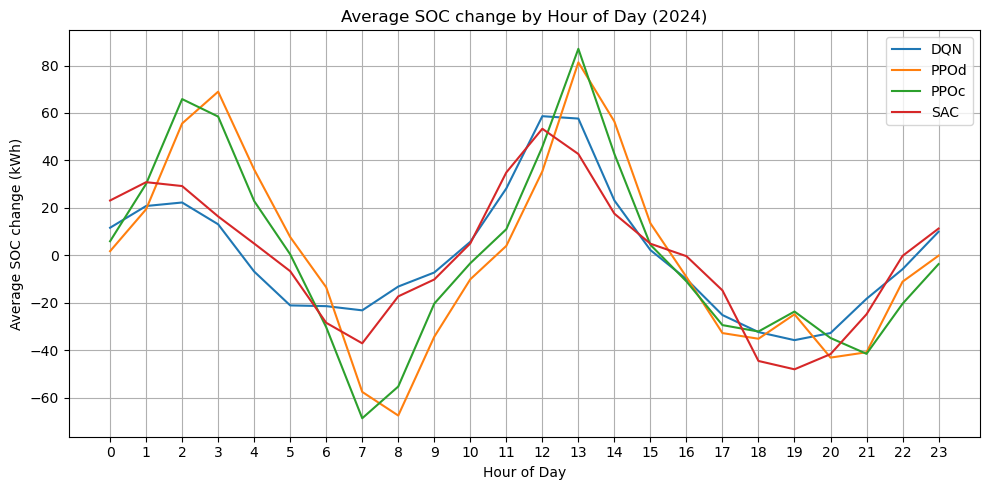

In [22]:
# Plot average SOC by hour of day for all methods (LEAR models, 2024)
methods = {
    "DQN": results_dqn_lear[0],
    "PPOd": results_PPOd_lear[0],
    "PPOc": results_PPOc_lear[0],
    "SAC": results_SAC_lear[0],
}

plt.figure(figsize=(10, 5))
for name, df in methods.items():
    if name == "Heuristic":
        soc_hourly = df['soc_kWh'].groupby(df.index.hour).mean()
    else:
        soc_hourly = df['soc_kWh'].groupby(df.index.hour).mean()
    plt.plot(soc_hourly.index, soc_hourly.values, marker='', label=name)

plt.title('Average SOC change by Hour of Day (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Average SOC change (kWh)')
plt.grid(True)
plt.xticks(range(24))
plt.legend()
plt.tight_layout()
plt.show()